## Preambule

In [1]:
# Plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from plotly.colors import n_colors
from plotly.subplots import make_subplots

## Input

In [2]:
rules = ["GF", "PC", "PCC", "AP", "GDR", "ECPC"]

## Read data

In [3]:
df_ar6_raw = pd.read_csv("X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_World_v1.1.csv")

In [4]:
df_ar6 = df_ar6_raw[
    df_ar6_raw.Variable.isin(
        [
            "Emissions|Kyoto Gases",
            "Emissions|CO2",
            "Emissions|CH4",
            "Emissions|N2O",
            "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|5.0th Percentile",
            "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|33.0th Percentile",
            "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile",
            "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|67.0th Percentile",
            "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|95.0th Percentile",
        ]
    )
]
df_ar6 = df_ar6.reset_index(drop=True)
idx = (
    df_ar6[(df_ar6.Variable == "Emissions|CH4") & (df_ar6["2100"] > 1e5)]
).index  # Removing erroneous CH4 scenarios
df_ar6 = df_ar6[~df_ar6.index.isin(idx)]
df_ar6 = df_ar6.reset_index(drop=True)

df_ar6_meta = pd.read_excel(
    "X:/user/dekkerm/Data/IPCC/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx",
    sheet_name="meta_Ch3vetted_withclimate",
)
mods = np.array(df_ar6_meta.Model)
scens = np.array(df_ar6_meta.Scenario)
modscens_meta = np.array([mods[i] + "|" + scens[i] for i in range(len(scens))])
df_ar6_meta["ModelScenario"] = modscens_meta
df_ar6_meta = df_ar6_meta[["ModelScenario", "Category", "Policy_category"]]

df_ar6_meta_c1 = df_ar6_meta[df_ar6_meta.Category.isin(["C1"])]
df_ar6_meta_c1 = df_ar6_meta_c1.reset_index(drop=True)
ms_c1 = np.array(df_ar6_meta_c1.ModelScenario)

df_ar6_meta_c2 = df_ar6_meta[df_ar6_meta.Category.isin(["C2"])]
df_ar6_meta_c2 = df_ar6_meta_c2.reset_index(drop=True)
ms_c2 = np.array(df_ar6_meta_c2.ModelScenario)

df_ar6_meta_c3 = df_ar6_meta[df_ar6_meta.Category.isin(["C3"])]
df_ar6_meta_c3 = df_ar6_meta_c3.reset_index(drop=True)
ms_c3 = np.array(df_ar6_meta_c3.ModelScenario)

mods = np.array(df_ar6.Model)
scens = np.array(df_ar6.Scenario)
modscens = np.array([mods[i] + "|" + scens[i] for i in range(len(scens))])
df_ar6["ModelScenario"] = modscens
df_ar6 = df_ar6.drop(["Model", "Scenario", "Unit", "Region"], axis=1)

In [5]:
dummy = df_ar6.melt(id_vars=["Variable", "ModelScenario"], var_name="Time", value_name="Value")
dummy["Time"] = np.array(dummy["Time"].astype(int))
dummy = dummy.set_index(["Variable", "ModelScenario", "Time"])
xr_scen = xr.Dataset.from_dataframe(dummy)
xr_scen = xr_scen.reindex(Time=np.arange(1990, 2101))
xr_scen = xr_scen.interpolate_na(dim="Time", method="linear")

In [6]:
def ms_temp(T, dT, R):
    return xr_scen.ModelScenario[
        np.where(
            (
                xr_scen.sel(
                    Variable="AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|"
                    + str(int(R * 100))
                    + ".0th Percentile",
                    Time=2100,
                ).Value
                < T + dT
            )
            & (
                xr_scen.sel(
                    Variable="AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|"
                    + str(int(R * 100))
                    + ".0th Percentile",
                    Time=2100,
                ).Value
                > T - dT
            )
        )[0]
    ]

In [7]:
def ms_t12(t1, t2):
    return xr_scen.ModelScenario[
        np.where(
            (
                xr_scen.sel(
                    Variable="AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile",
                    Time=2100,
                ).Value
                <= t2
            )
            & (
                xr_scen.sel(
                    Variable="AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile",
                    Time=2100,
                ).Value
                >= t1
            )
        )[0]
    ]

## Plots

In [8]:
ch4_2020 = xr_scen.sel(Variable="Emissions|CH4", Time=2020).Value.mean()
n2o_2020 = xr_scen.sel(Variable="Emissions|N2O", Time=2020).Value.mean()

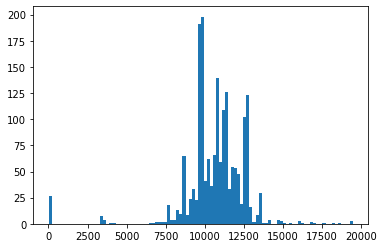

In [9]:
plt.hist(xr_scen.sel(Variable="Emissions|N2O", Time=2020).Value, bins=100)
plt.show()

In [10]:
def func(x, a, b):
    return a * x + b


def func1d(x, b):
    return -0.00023723 * x + b


from scipy.optimize import curve_fit

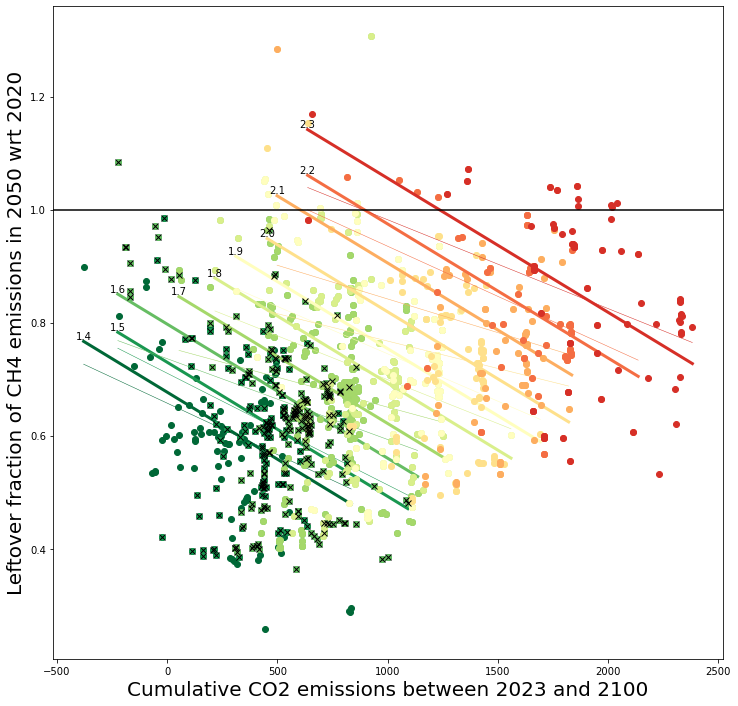

In [11]:
fig, ax = plt.subplots(figsize=(12, 12), facecolor="white")
a_list = []
b_list = []
b2_list = []
for T_i, T in enumerate(np.linspace(1.4, 2.3, 10)):
    col = plt.cm.RdYlGn_r(T_i / 10)
    x = (
        xr_scen.sel(
            Variable="Emissions|CO2",
            Time=np.arange(2023, 2101),
            ModelScenario=ms_temp(T, 0.1, 0.50),
        ).Value.sum(dim="Time")
        / 1e3
    )
    y = (
        xr_scen.sel(Variable="Emissions|CH4", Time=2040, ModelScenario=ms_temp(T, 0.1, 0.50)).Value
        / ch4_2020
    )
    ax.plot(x, y, "o", c=col)
    if T == 1.5:
        ax.plot(x, y, "x", ms=6, c="k", zorder=1e9)
    y = y[~np.isnan(x)]
    x = x[~np.isnan(x)]
    x = x[~np.isnan(y)]
    y = y[~np.isnan(y)]
    popt, pcov = curve_fit(func, x, y)
    ax.plot(
        np.linspace(np.min(x), np.max(x), 100),
        func(np.linspace(np.min(x), np.max(x), 100), popt[0], popt[1]),
        c=col,
        lw=0.5,
    )
    a_list.append(popt[0])
    b_list.append(popt[1])
    popt, pcov = curve_fit(func1d, x, y)
    ax.plot(
        np.linspace(np.min(x), np.max(x), 100),
        func1d(np.linspace(np.min(x), np.max(x), 100), popt[0]),
        c=col,
        lw=3,
    )
    ax.text(np.min(x), func1d(np.min(x), popt[0]), np.round(T, 1), ha="center", va="bottom")
    b2_list.append(popt[0])

ax.set_xlabel("Cumulative CO2 emissions between 2023 and 2100", fontsize=20)
ax.set_ylabel("Leftover fraction of CH4 emissions in 2050 wrt 2020", fontsize=20)
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([-1e3, 1e5], [1, 1], c="k")